<a href="https://colab.research.google.com/github/luuleitner/dasIT/blob/main/beamform_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
# install dasIT from the GitHub repository

!pip install git+https://github.com/luuleitner/dasIT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/luuleitner/dasIT to /tmp/pip-req-build-geq1buv7
  Running command git clone -q https://github.com/luuleitner/dasIT /tmp/pip-req-build-geq1buv7
  Created wheel for dasIT: filename=dasIT-1.0-py3-none-any.whl size=23611 sha256=33d07460a22941386a25491733166c6dc8f70e8db9d1ffafc5c5db363cd96f90
  Stored in directory: /tmp/pip-ephem-wheel-cache-ire0gjvt/wheels/66/36/37/5de611735f2493c3d0eec5967a59a90a26913ec1fa94789258
Successfully built dasIT


In [15]:
import os
import numpy as np
from datetime import datetime

from dasIT.data.loader import RFDataloader, TDloader, TGCloader
from dasIT.features.transducer import transducer
from dasIT.features.medium import medium
from dasIT.features.tgc import tg_compensation
from dasIT.src.delays import planewave_delays
from dasIT.src.apodization import apodization
from dasIT.src.das_bf import RXbeamformer
from dasIT.features.signal import RFfilter, fftsignal, analytic_signal
from dasIT.features.image import interp_lateral
from dasIT.visualization.signal_callback import amp_freq_1channel
from dasIT.visualization.image_callback import plot_signal_grid, plot_signal_image

In [3]:
# import 5 RF-data frames captured on a Verasonics Vantage 256 system*, using a GE-9LD transducer, and a CIRS generalpurpose ultrasound phantom.
#
# * Leitner et al. 2020, "Detection of Motor Endplates in Deep and Pennate Skeletal Muscles in-vivo using Ultrafast Ultrasound",
# 2020 IEEE International Ultrasonics Symposium (IUS).
#

rfdata_path = '/content/rfdata'

if os.path.exists(rfdata_path) == False:
  os.mkdir(rfdata_path)
  os.chdir(rfdata_path)
  !wget -i https://raw.githubusercontent.com/luuleitner/dasIT/main/example_data/CIRSphantom_GE9LD_VVantage/COLABdownload_url.txt

os.chdir(rfdata_path)

--2022-08-07 19:50:29--  https://raw.githubusercontent.com/luuleitner/dasIT/main/example_data/CIRSphantom_GE9LD_VVantage/COLABdownload_url.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448 [text/plain]
Saving to: ‘COLABdownload_url.txt’

COLABdownload_url.t 100%[===================>]     448  --.-KB/s    in 0s      

2022-08-07 19:50:29 (27.6 MB/s) - ‘COLABdownload_url.txt’ saved [448/448]

--2022-08-07 19:50:29--  https://raw.githubusercontent.com/luuleitner/dasIT/main/example_data/CIRSphantom_GE9LD_VVantage/CIRS_phantom.h5
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 31465528 (30M) [application/octet-stream]
Saving to: ‘CIRS_phantom.h5’

CIRS_phantom.h5     100%[=================

#dasIT Transducer and Medium

In [7]:
# dasIT transducer
physical_transducer = TDloader('transducer.csv')
dasIT_transducer = transducer(center_frequency_hz=physical_transducer.transducer['center frequency'].dropna().to_numpy(dtype='float', copy=False),  # [Hz]
                              bandwidth_hz=physical_transducer.transducer['bandwidth'].dropna().to_numpy(dtype='float', copy=False),    # [Hz]
                              adc_ratio=4,  # [-]
                              transducer_elements_nr=physical_transducer.transducer['number of elements'].dropna().to_numpy(dtype='float', copy=False), # [#]
                              element_pitch_m=physical_transducer.transducer['element pitch'].dropna().to_numpy(dtype='float', copy=False), # [m]
                              pinmap=physical_transducer.transducer['pinmap'].dropna().to_numpy(dtype='int', copy=False),   # [-]
                              pinmapbase=1, # [-]
                              elevation_focus=0.028, # [m]
                              focus_number=None,
                              totalnr_planewaves=1,     # [-]
                              planewave_angle_interval=[0,0],   # [rad]
                              axial_cutoff_wavelength=5,  # [#]
                              speed_of_sound_ms = 1540)  # [m/s]

In [8]:
# dasIT medium
dasIT_medium = medium(speed_of_sound_ms = 1540, # [m/s]
                      center_frequency = dasIT_transducer.center_frequency, # [Hz]
                      sampling_frequency = dasIT_transducer.sampling_frequency, # [Hz]
                      max_depth_wavelength = 177,   # [#]
                      lateral_transducer_element_spacing = dasIT_transducer.lateral_transducer_spacing, # [m]
                      axial_extrapolation_coef = 1.05,  # [-]
                      attenuation_coefficient= 0.75,   # [dB/(MHz^y cm)]
                      attenuation_power=1.5   # [-]
                      )

#Load and Preprocess RF-data

In [11]:
####################################################################
#------------------------- RFData Loading -------------------------#

### Load RF Data
RFdata = RFDataloader('CIRS_phantom.h5')

### Preprocess (Clip and Sort) RF Data
# Samples start: at first recorded echo (number of wavelength distance is provided from vendor)
# -> null out the rest to not overshadow the real results
# Samples end: at penetration depth -> clip rest of samples without data
# If necessary sort the transducer channels according to the pin map to get the channels first-last channel
RFdata.signal[:dasIT_transducer.start_depth_rec_samples, :, :] = 0
RFdata.signal = RFdata.signal[:dasIT_medium.rx_echo_totalnr_samples, dasIT_transducer.transducer_pinmap, :]


#Signal Preprocessing

###Time Gain Compensation

In [12]:
####################################################################
#---------------------- Time Gain Compensation --------------------#

# Load tgc-waveform
tgc_cntrl_points = TGCloader(controlpt_path='tgc_cntrl_pt.csv')
# Apply TGC
TGCsignals = tg_compensation(signals=RFdata.signal,
                             medium=dasIT_medium,
                             center_frequency=dasIT_transducer.center_frequency,
                             cntrl_points=tgc_cntrl_points,
                             mode='points')

###Filtering

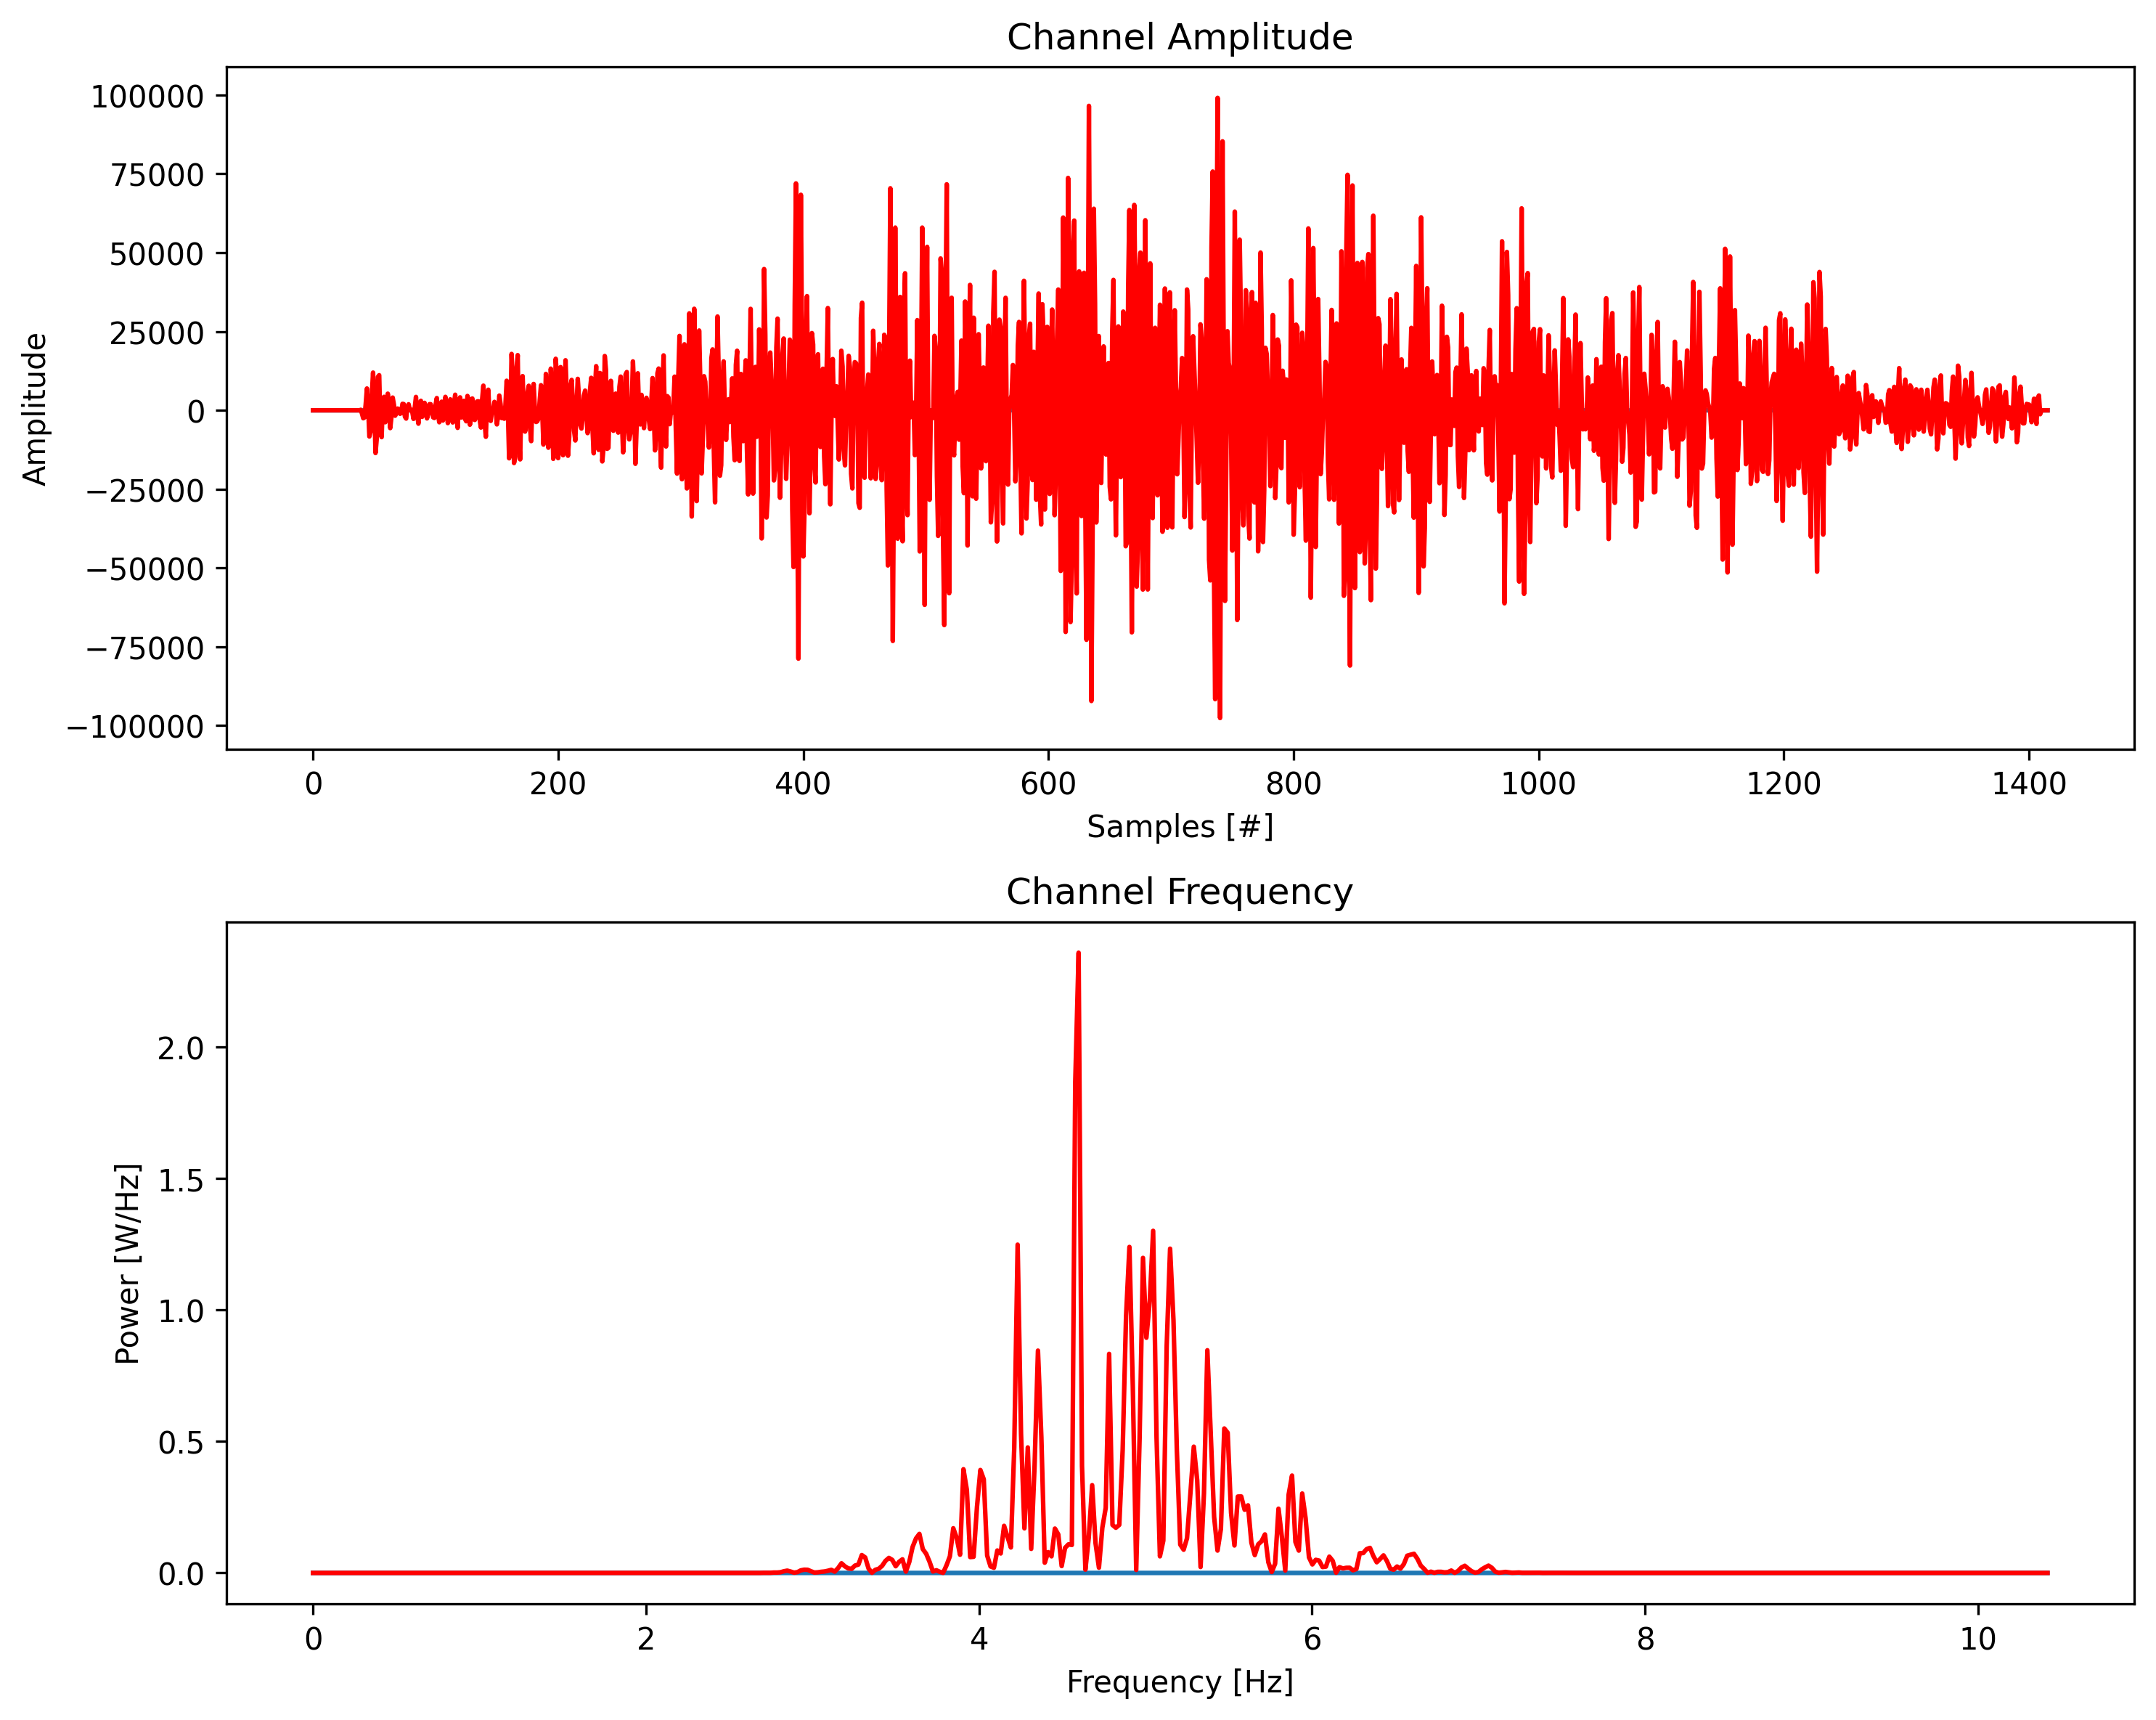

/usr/local/lib/python3.7/dist-packages/dasIT/features/signal.py:86: RuntimeWarning: divide by zero encountered in log10
  logcomp_signal = (20 * np.log10(envelope(signal))) - np.nanmax((20 * np.log10(envelope(signal))))
/usr/local/lib/python3.7/dist-packages/dasIT/features/signal.py:86: RuntimeWarning: invalid value encountered in log10
  logcomp_signal = (20 * np.log10(envelope(signal))) - np.nanmax((20 * np.log10(envelope(signal))))


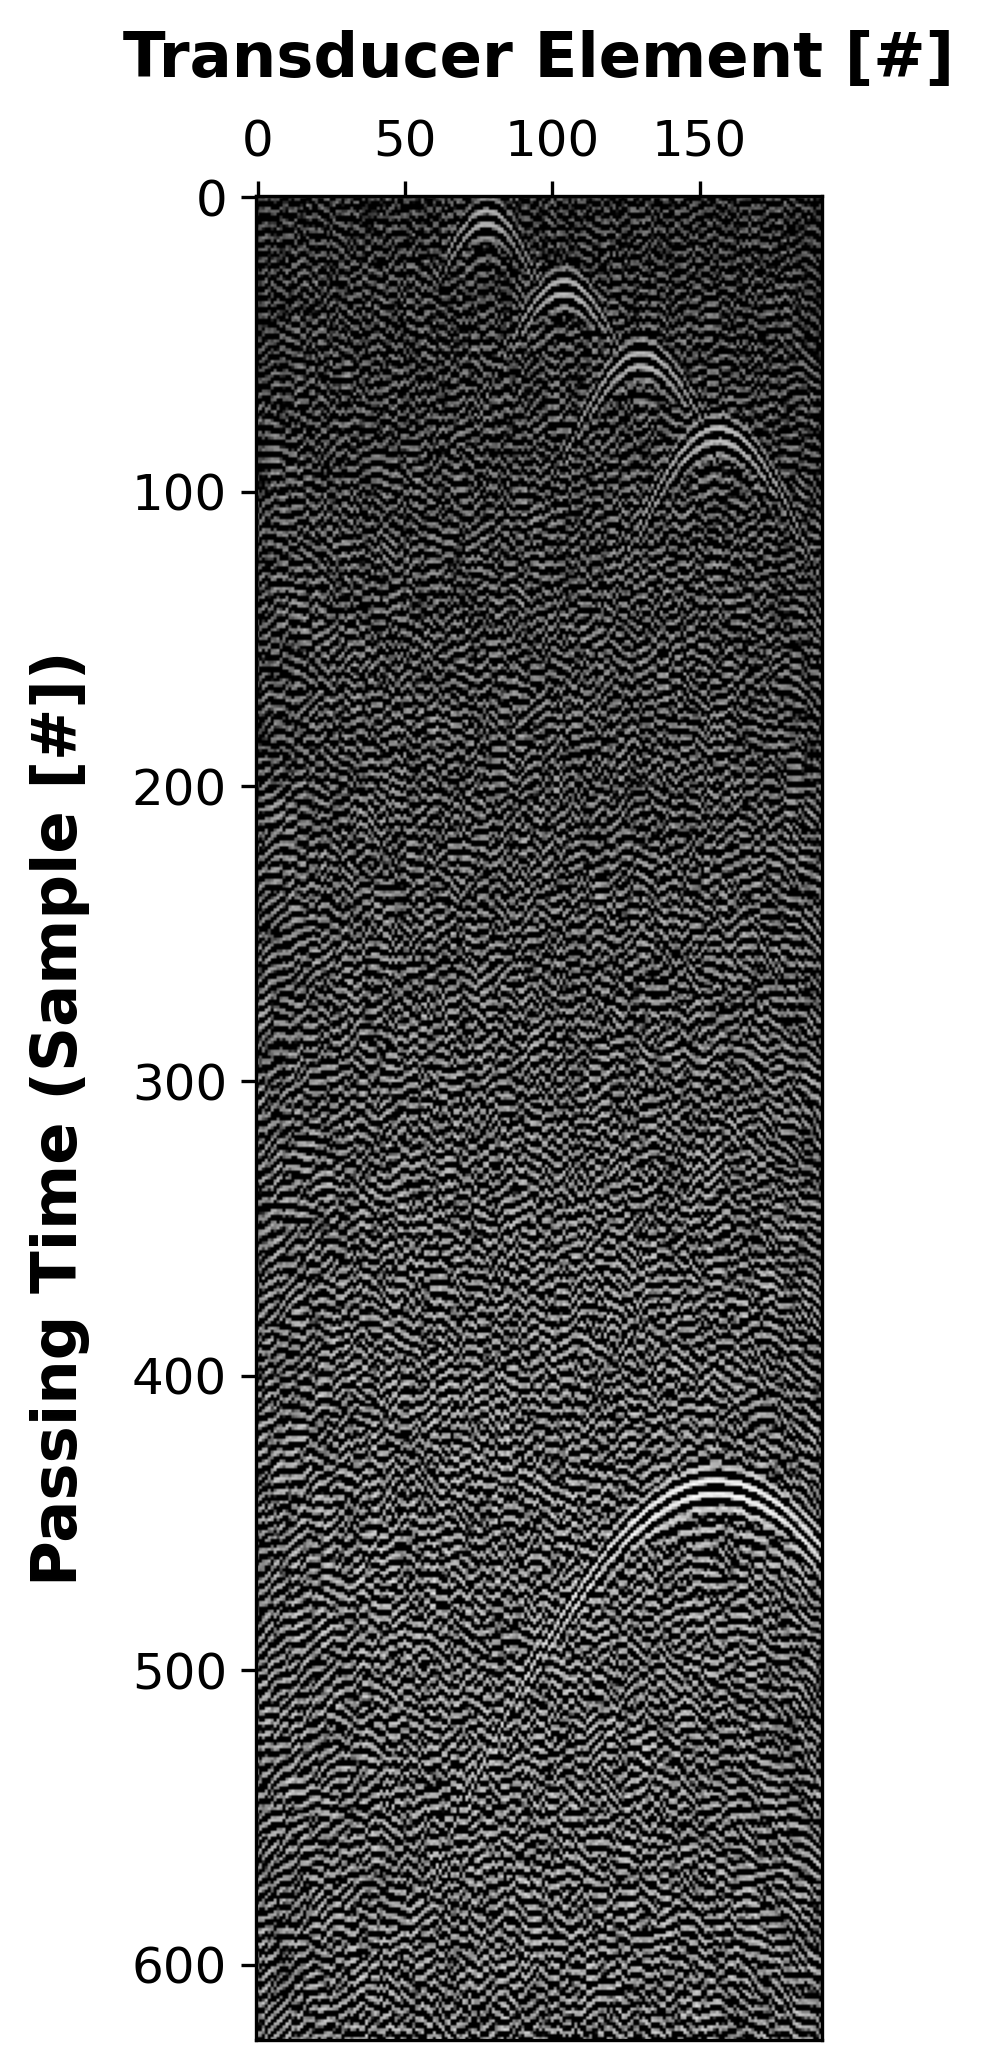

In [13]:
####################################################################
#---------------------------- Filtering ---------------------------#

### Filter RF Data
RFdata_filtered = RFfilter(signals=TGCsignals.signals,
                           fcutoff_band=dasIT_transducer.bandwidth,
                           fsampling=dasIT_transducer.sampling_frequency,
                           type='gaussian',
                           order=10)

# Plot Filter Results of all channels
# transducer_channel_map(RFdata.signal[:,:,0], RFdata.signal.shape[1], cmode='mono')

# Plot Filter Results of single channel
amp_freq_1channel(RFdata.signal[:,0,0],
                  fftsignal(RFdata.signal[:,0,0], dasIT_transducer.sampling_frequency),
                  RFdata_filtered.signal[:,0,0],
                  fftsignal(RFdata_filtered.signal[:,0,0], dasIT_transducer.sampling_frequency),
                  mode='overlay')

plot_signal_image(RFdata_filtered.signal[:,:,0], compression=True, dbrange=60)

###Convert to analytical signal

/usr/local/lib/python3.7/dist-packages/dasIT/features/signal.py:90: ComplexWarning: Casting complex values to real discards the imaginary part
  return logcomp_signal.astype(np.float64)


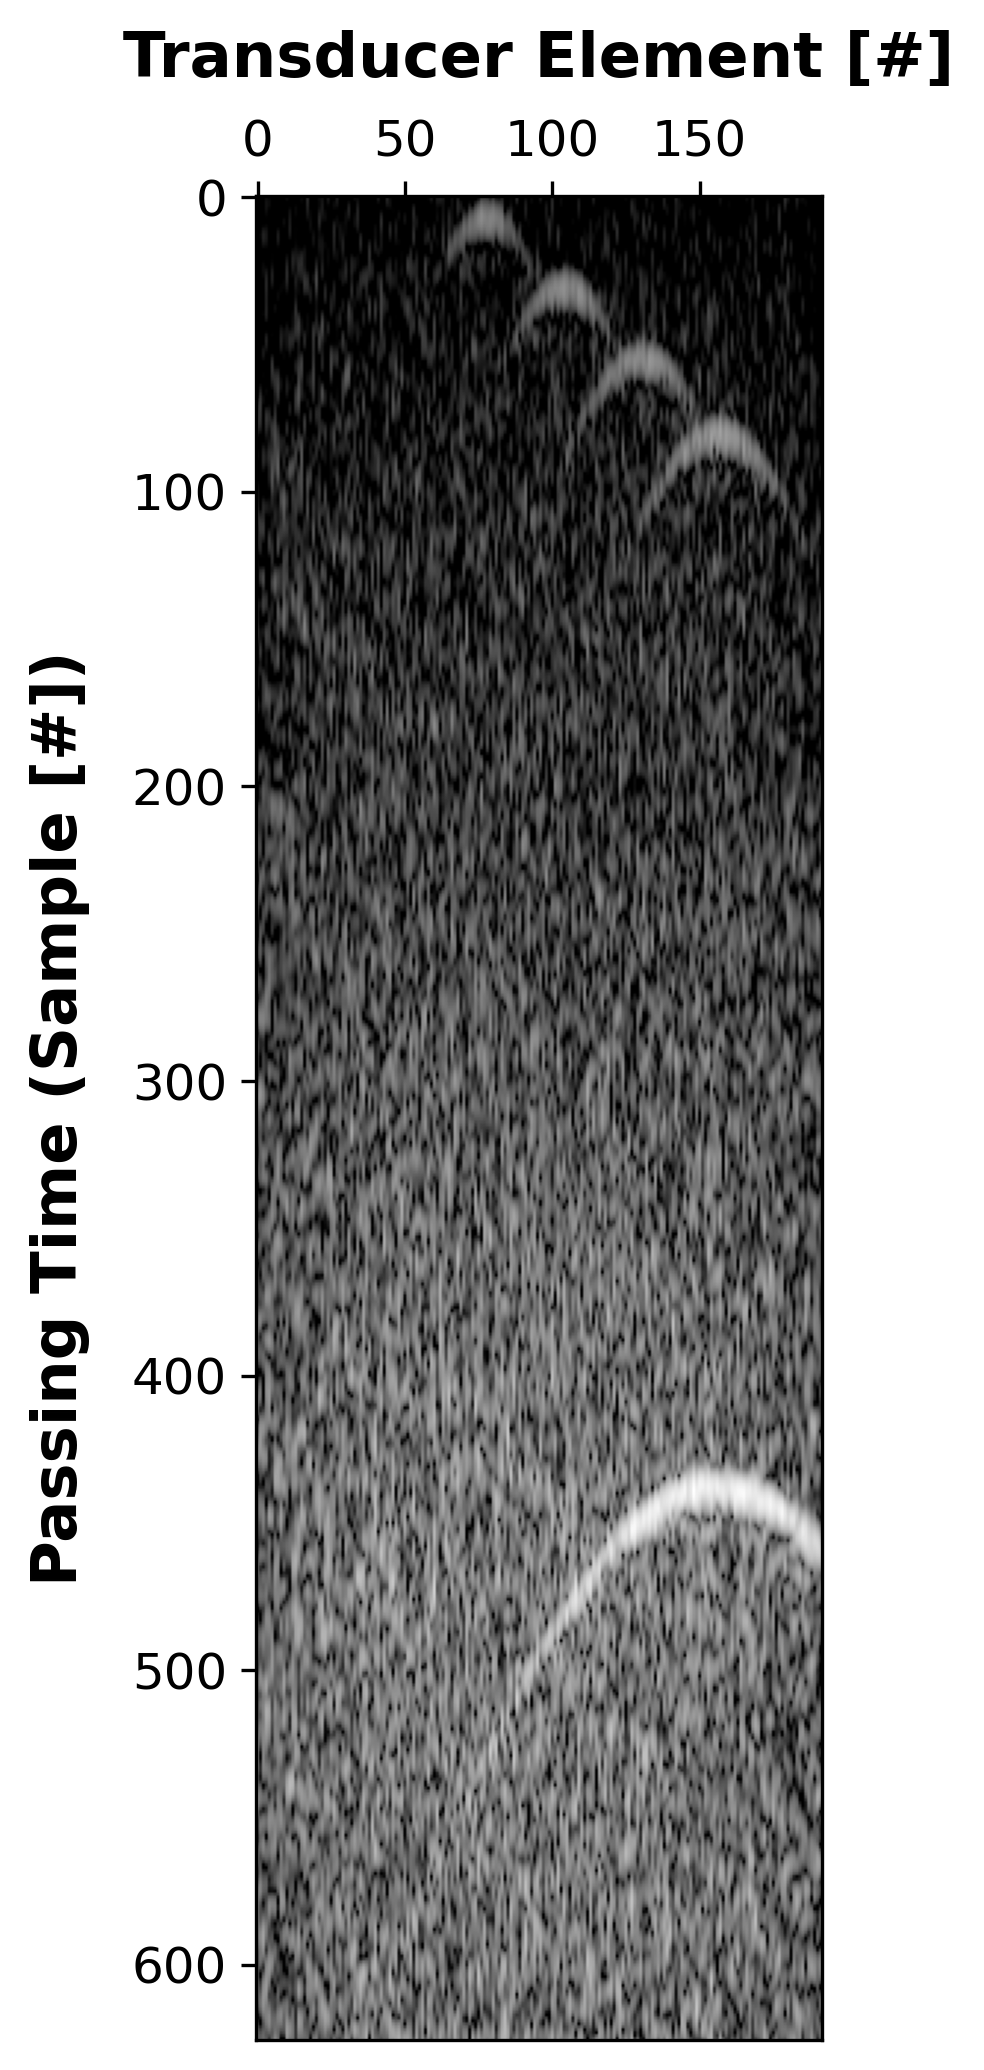

In [16]:
####################################################################
#------------------------ Analytical Signal -----------------------#

### Hilbert Transform
RFdata_analytic = analytic_signal(np.squeeze(RFdata_filtered.signal), interp=False)

# IQsignal_1ch(RFdata_analytic,
#              RFdata_filtered,
#              mode='window',
#              start=400,
#              stop=600)

plot_signal_image(RFdata_analytic[:,:,0], compression=True, dbrange=35)

#Beamforming

###Element directivity and focus

In [17]:
####################################################################
#-------------------------- Apodization Table --------------------------#

apodization = apodization(delays=None,
                          medium=dasIT_medium.medium,
                          transducer=dasIT_transducer,
                          apo='rec',
                          angles=dasIT_transducer.planewave_angles())

###Delay tables

In [18]:
####################################################################
#-------------------------- Delay Tables --------------------------#

### DAS delay tabels for tilted planewaves
delay_table = planewave_delays(medium=dasIT_medium.medium,
                               sos=dasIT_medium.speed_of_sound,
                               fsampling=dasIT_transducer.sampling_frequency,
                               angles=dasIT_transducer.planewave_angles())


# plot_signal_grid(delay_table.sample_delays[:,:,0], dasIT_medium.medium, compression=False, dbrange=60)


Time to initialize delay tables: 1.749486 [s]


###Beamforming

In [19]:
####################################################################
#-------------------------- Beamforming ---------------------------#
start_das_timing = datetime.now()

# Mask images areas in axial direction which have been included for reconstruction
# but are not part of the actual image.
RFsignals = RFdata_analytic[:,:,0]

RFsignals = np.expand_dims(RFsignals, 2)
RFsignals = np.repeat(RFsignals, RFsignals.shape[1], axis=2)
RFsignals = np.expand_dims(RFsignals, 3)

BFsignals = RXbeamformer(signals=RFsignals,
                         delays=delay_table.sample_delays,
                         apodization=apodization.table)

# BFsignals = RXbeamformer(signals=RFsignals,
#                          delays=delay_table.sample_delays)

#Image Formation

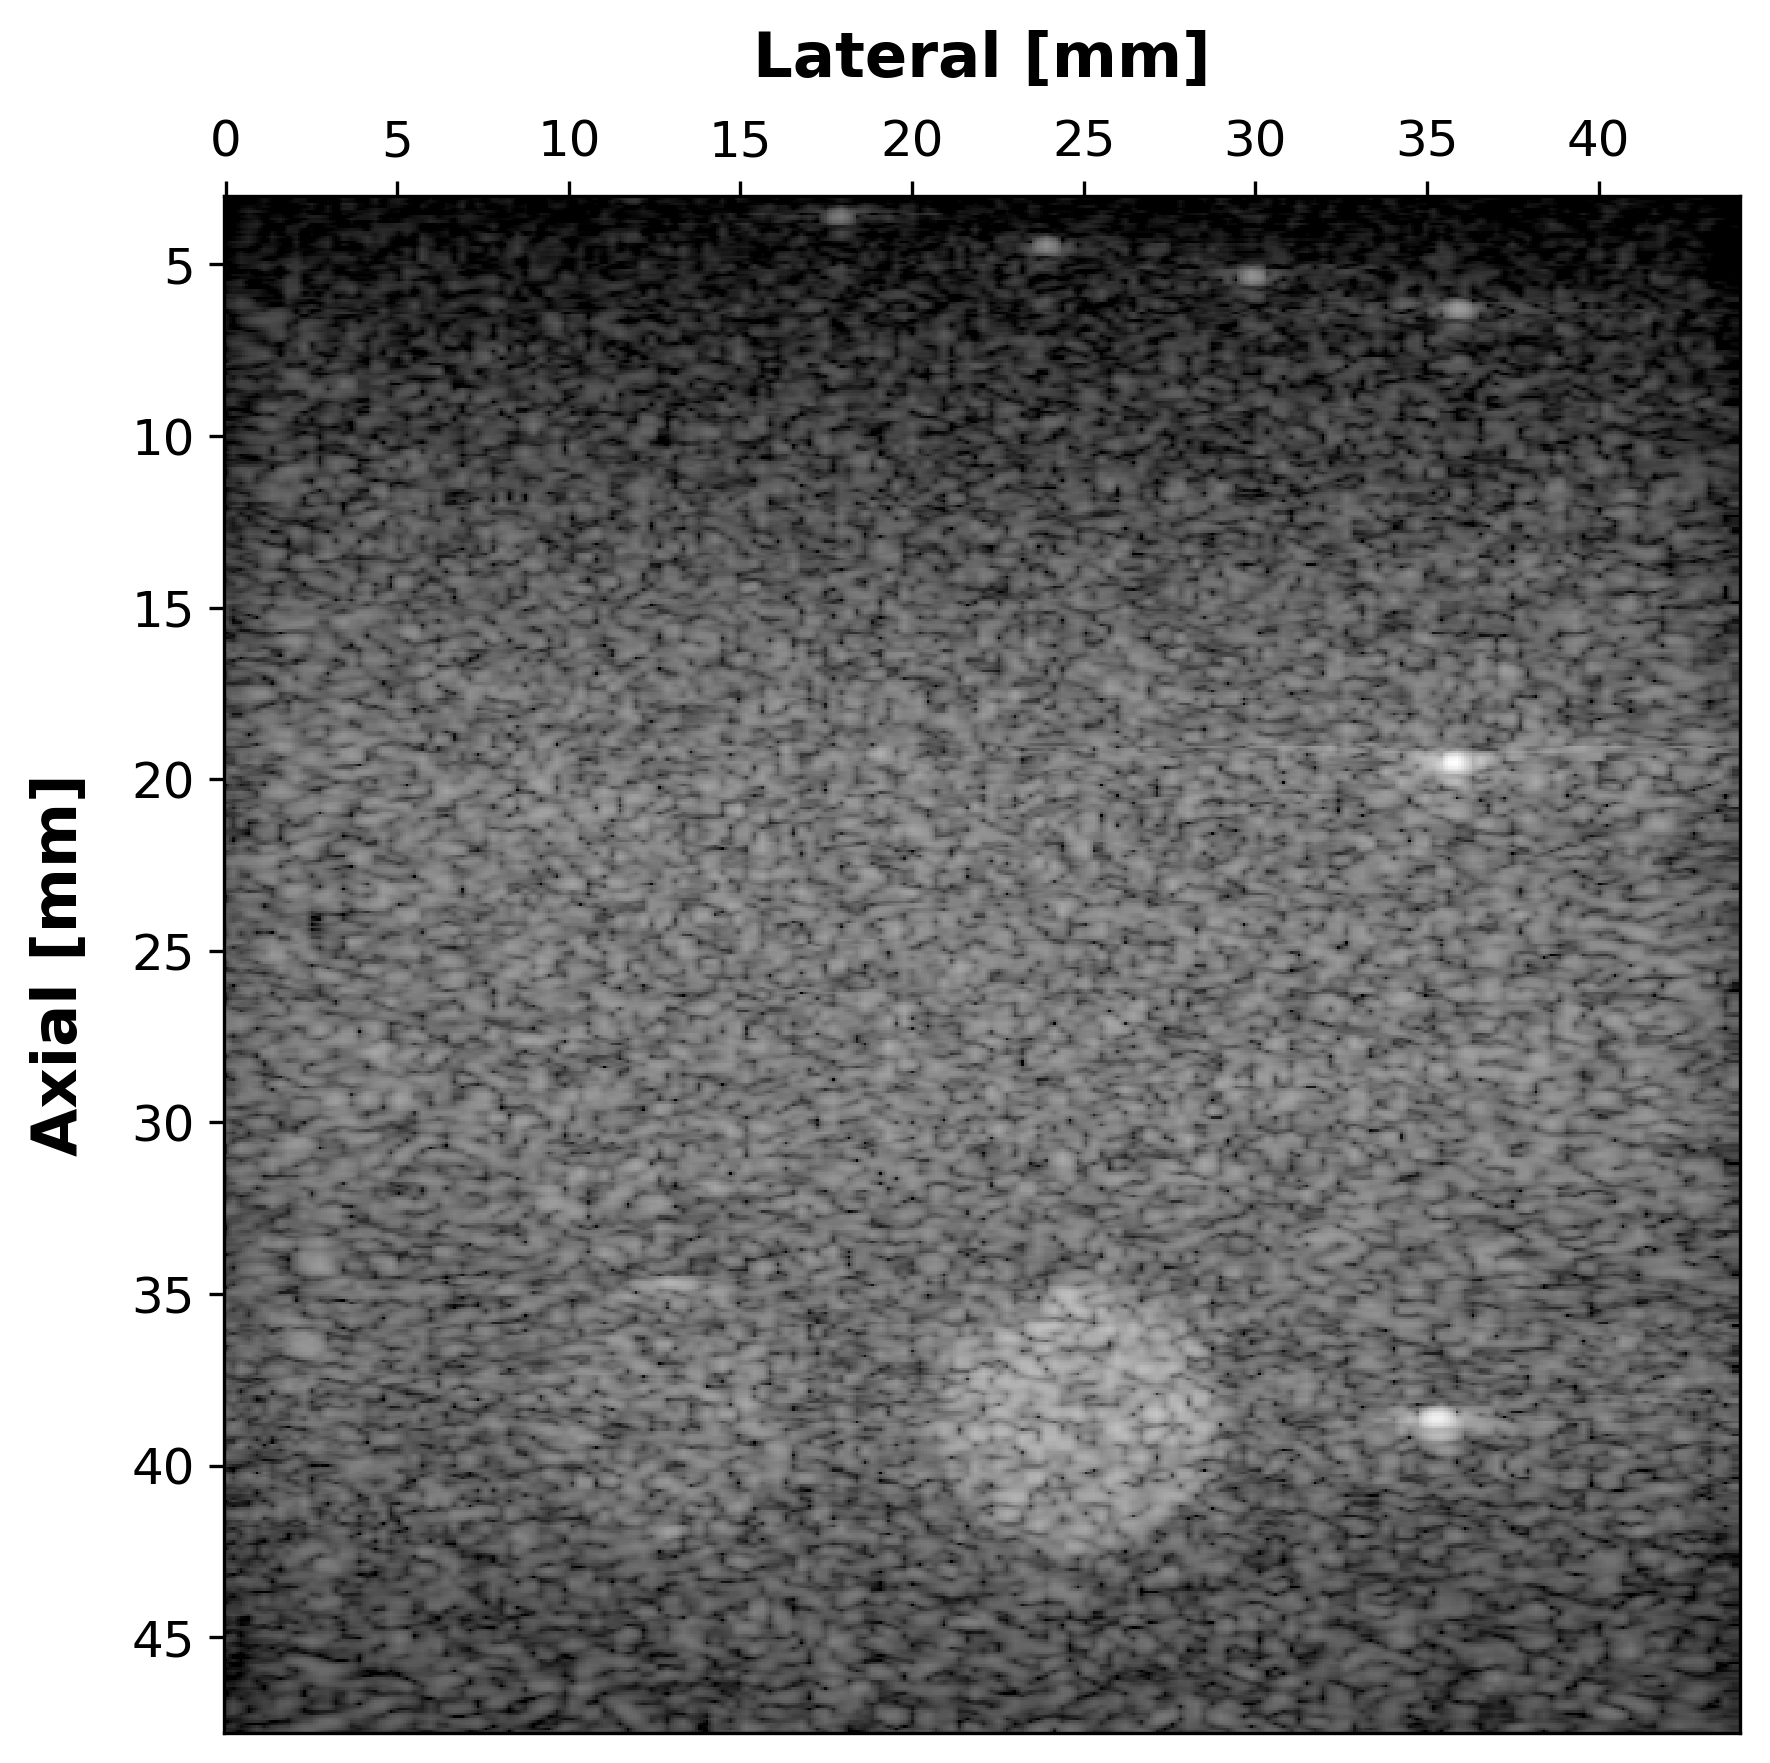

In [20]:
####################################################################
#------------------------ Image Formation --------------------------

# Envelope
BFsignals.envelope = abs(BFsignals.frame)

# Interpolate over Lateral space
BFsignals.interpolated = interp_lateral(signals=BFsignals.envelope,
                                        transducer=dasIT_transducer,
                                        medium=dasIT_medium,
                                        scale=3)


# Plot image
plot_signal_grid(signals=BFsignals.interpolated.signals_lateral_interp,
                 axis_vectors_xz=BFsignals.interpolated.imagegrid_mm,
                 axial_clip=[dasIT_transducer.start_depth_rec_m, None],
                 compression=True,
                 dbrange=58)